# Трансформеры || Transformers

### Что такое трансформеры?

**Трансформеры** —  один из важнейших инструментов машинного обучения. Популярность трансформеров взлетела до небес в связи с появлением больших языковых моделей вроде ChatGPT, GPT-4 от Open AI и LLama компании Meta. Эти модели созданы на основе трансформерной архитектуры и демонстрируют отличную производительность в понимании и синтезе естественных языков.

### Трансформеры нормального человека

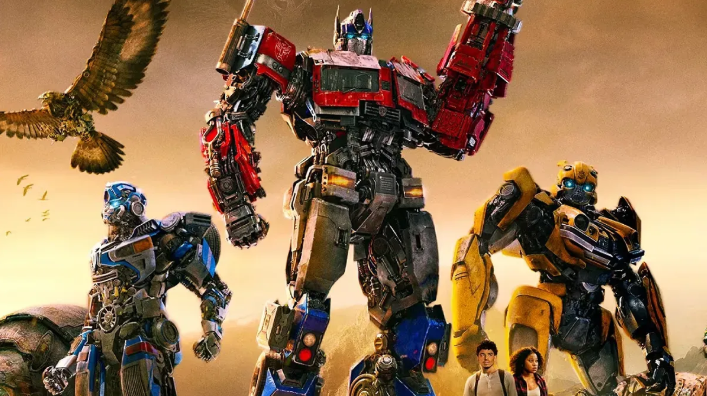

### Трансформеры ML специалиста

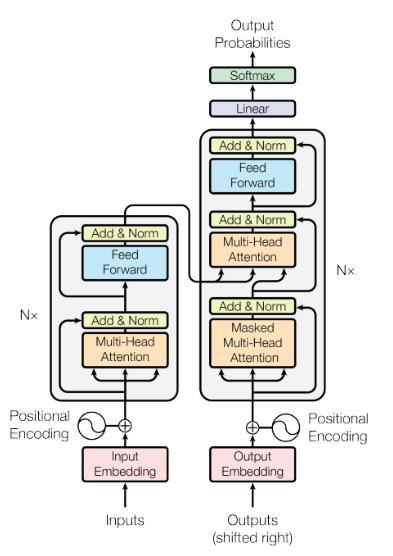

Входные данные (например, текст) проходят через **Embedding Layer**, чтобы преобразовать слова в векторы.

К этим векторам добавляется **Positional Encoding**, чтобы учесть порядок слов.

Данные поступают в Encoder, где применяются **Self-Attention** и **Feed-Forward Networks**.

Если используется **Decoder**, то он генерирует выходную последовательность на основе закодированного представления.

Выход **Decoder** проходит через финальный линейный слой и **softmax**, чтобы получить вероятности для каждого слова.

Архитектура была представлена в 2017 году в статье **"Attention is All You Need"**. Они стали революционными в области обработки естественного языка (NLP) и заменили собой более старые подходы, такие как рекуррентные нейронные сети (RNN) и сети с долгой краткосрочной памятью (LSTM).

Почему трансформеры?

*   Они быстрее и эффективнее, чем RNN и LSTM, благодаря параллельной обработке данных.
*   Они лучше справляются с длинными последовательностями благодаря механизму внимания (attention).
*   Легко маштабируются
*   Они стали основой для современных моделей, таких как GPT, BERT, T5 и других.

### Где теперь используются трансформеры ?

Трансформеры применяются в самых разных задачах:

*   Машинный перевод: Например, Google Translate использует трансформеры.
*   Генерация текста: Модели вроде GPT-3 и GPT-4 создают тексты, которые трудно отличить от написанных человеком.
*   Классификация текста: Определение тональности, категоризация и т.д.
*   Ответы на вопросы: Модели вроде BERT используются для поиска ответов в тексте.
*   Синтез речи и музыки: Трансформеры используются для генерации аудио.

## **Ключевые компоненты трансформера**

### Self-Attention


**Self-Attention** — это механизм, который позволяет модели вычислять "внимание" между всеми элементами последовательности. Например, в предложении "The cat sat on the mat" модель поймет, что "cat" связано с "sat", а "mat" связано с "on".

Как работает:

Для каждого элемента последовательности (например, слова) модель вычисляет три вектора:



*   Query (Q): Вектор запроса — что ищем.
*   Key (K): Вектор ключа — с чем сравниваем.
*   Value (V): Вектор значения — что возвращаем.

Для каждого слова модель вычисляет внимание **(attention scores)** относительно всех других слов в последовательности. Это делается с помощью скалярного произведения векторов Query и Key.

Затем **attention scores** нормализуются с помощью функции softmax, чтобы получить веса внимания.

Наконец, модель комбинирует значения (Value) с весами внимания, чтобы получить итоговое представление слова.

Формула Self-Attention:

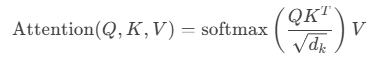

In [ ]:
import torch
import torch.nn.functional as F

def self_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)
    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, V)
    return attention_weights, output

# Пример использования
sentence = input("Enter a sentence: ")
words = sentence.split()
d_model = 8
Q = torch.randn(len(words), d_model)
K = torch.randn(len(words), d_model)
V = torch.randn(len(words), d_model)

attention_weights, output = self_attention(Q, K, V)

print("Attention weights:")
for i, word in enumerate(words):
    print(f"{word}: {attention_weights[i].detach().numpy()}")

print("\nOutput:")
print(output)

###  Multi-Head Attention

**Multi-Head Attention** — это расширение Self-Attention, которое позволяет модели одновременно фокусироваться на разных аспектах данных. Например, одна "голова" может обращать внимание на синтаксические связи, а другая — на семантические.

Как работает:

Входные данные (Q, K, V) проецируются в несколько разных пространств (по одному для каждой "головы").

Каждая "голова" вычисляет Self-Attention независимо, но с разными весовыми матрицами.

Результаты всех голов объединяются (конкатенируются) и проецируются обратно в исходное пространство.

Формула Multi-Head Attention:

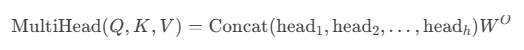

In [ ]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, query, key, value, mask=None, return_attention=False):
      batch_size = query.size(0)

      Q = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
      K = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
      V = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

      energy = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

      if mask is not None:
          if mask.dim() == 3:
              mask = mask.unsqueeze(1)
          energy = energy.masked_fill(mask == 0, float('-inf'))

      attention = torch.softmax(energy, dim=-1)
      out = torch.matmul(attention, V)

      out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_size)
      out = self.fc_out(out)

      if return_attention:
          return out, attention  # возвращаем и результат, и attention
      return out

### Positional encoding

Трансформеры не имеют встроенного понимания порядка слов, поэтому **positional encoding** добавляет информацию о позиции каждого слова в последовательности. Обычно это делается с помощью синусов и косинусов.

Зачем нужно:

*   Чтобы модель учитывала порядок слов в предложении.
*   Позволяет трансформеру работать с последовательностями переменной длины.

Для позиции pos и размерности i:

[0, 0, 0]

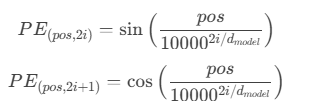

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_length, embed_size)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-np.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

### Feed-Forward Networks (Полносвязные сети)

После механизма внимания применяется простая полносвязная сеть. Она добавляет нелинейность и помогает модели лучше обрабатывать данные.

За счет добавление слоев прямого распространения увеличивается вырзаительность модели, добавляются нелинейные преобразования.

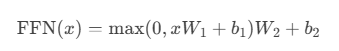

In [ ]:
class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_model, d_ff)
        self.linear2 = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

d_model = 64
d_ff = 256
ff = FeedForward(d_model, d_ff)

x = torch.randn(1, 5, d_model)
print("Input Shape:", x.shape)

output = ff(x)
print("Output Shape:", output.shape)

### И как в итоге это все работает вместе?

1.   Входные данные (например, текст) проходят через **Embedding Layer**, чтобы преобразовать слова в векторы.
2.   К этим векторам добавляется **Positional Encoding**, чтобы учесть порядок слов.
3.   Данные поступают в **Encoder**, где применяются **Self-Attention** и **Feed-Forward Networks**.
4.   Если используется **Decoder**, то он генерирует выходную последовательность на основе закодированного представления.
5.   Выход **Decoder** проходит через финальный линейный слой и **softmax**, чтобы получить вероятности для каждого слова.

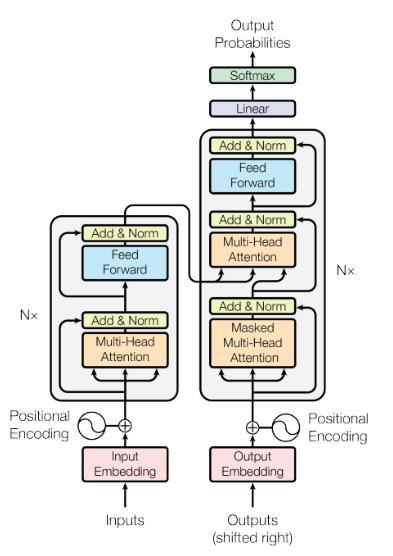

# Собираем трансформер

Импорт и создание данных

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Пример данных: упрощённый перевод
data = [
    ("hello", "bonjour"),
    ("soldier", "soldat"),
    ("friend", "ami"),
    ("dear", "cher"),
    ("mom", "maman"),
    ("how", "comment"),
    ("my", "mon"),
    ("brother", "frère"),
    ("world", "le monde"),
    ("is", "est"),
    ("hello world", "bonjour le monde"),
    ("how are you", "comment allez-vous"),
    ("my friend is soldier", "mon ami est soldat"),
    ("dear friend", "cher ami"),
    ("hello mom", "bonjour maman"),
    ("mom is soldier", "maman est soldat"),
    ("dear soldier", "cher soldat"),
    ("dear brother", "cher frère")
]

Токенизация и создание словаря

In [ ]:
# Создаём словари
src_vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3, "hello": 4, "world": 5}
tgt_vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3, "bonjour": 4, "le monde": 5}

# Добавляем слова в словари
for src, tgt in data:
    for word in src.split():
        if word not in src_vocab:
            src_vocab[word] = len(src_vocab)
    for word in tgt.split():
        if word not in tgt_vocab:
            tgt_vocab[word] = len(tgt_vocab)

# Обратные словари
src_idx_to_word = {idx: word for word, idx in src_vocab.items()}
tgt_idx_to_word = {idx: word for word, idx in tgt_vocab.items()}

max_src_len = max(len(src.split()) for src, _ in data) + 2  # +2 для <sos> и <eos>
max_tgt_len = max(len(tgt.split()) for _, tgt in data) + 2
max_length = max(max_src_len, max_tgt_len)  # Общая максимальная длина
print(f"Max source length: {max_src_len}, Max target length: {max_tgt_len}")

Задаем гиперпараметры необходимые для обучения

In [ ]:
# Параметры
embed_size = 64
num_heads = 4
num_layers = 2
batch_size = 2
learning_rate = 0.0001
num_epochs = 500

Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_length, embed_size)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-np.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

Multi-Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size # Размерность входных данных (длина вектора слова)
        self.num_heads = num_heads # Количество "голов" внимания
        self.head_dim = embed_size // num_heads # Размерность каждой "головы"

        # Линейные слои для преобразования Q, K, V
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, query, key, value, mask=None, return_attention=False):
      batch_size = query.size(0)

      Q = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
      K = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
      V = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

      energy = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

      if mask is not None:
        if mask.dim() == 3:
            mask = mask.unsqueeze(1)
        energy = energy.masked_fill(mask == 0, float('-inf'))

      attention = torch.softmax(energy, dim=-1)
      out = torch.matmul(attention, V)

      out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_size)
      out = self.fc_out(out)

      if return_attention:
        return out, attention  # <-- возвращаем и output, и матрицу attention

      return out

Реализуем Трансформер, соберем его из написанных нам частей, и функций PyTorch.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, max_length):
        super(Transformer, self).__init__()
        # Встраивание входных слов в числа
        self.encoder_embedding = nn.Embedding(src_vocab_size, embed_size)
        # Встраивание выходных слов в числа
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        # Позиционное кодирование
        self.positional_encoding = PositionalEncoding(embed_size, max_length)

        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            nn.ModuleDict({
                'self_attn': MultiHeadAttention(embed_size, num_heads), # Механизм внимания
                'ffn': nn.Sequential( # Полносвязная сеть (FFN)
                    nn.Linear(embed_size, embed_size * 4),
                    nn.ReLU(),
                    nn.Linear(embed_size * 4, embed_size)
                ),
                'norm1': nn.LayerNorm(embed_size), # Нормализация после Self-Attention
                'norm2': nn.LayerNorm(embed_size) # Нормализация после FFN
            }) for _ in range(num_layers) # Создаем num_layers таких блоков
        ])

        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            nn.ModuleDict({
                'self_attn': MultiHeadAttention(embed_size, num_heads), # Механизм внимания с маской
                'enc_attn': MultiHeadAttention(embed_size, num_heads), # Внимание Кодировщик-Декодировщик
                'ffn': nn.Sequential(
                    nn.Linear(embed_size, embed_size * 4),
                    nn.ReLU(),
                    nn.Linear(embed_size * 4, embed_size)
                ),
                'norm1': nn.LayerNorm(embed_size), # Нормализация после Decoder Self-Attention
                'norm2': nn.LayerNorm(embed_size), # Нормализация после Encoder-Decoder Attention
                'norm3': nn.LayerNorm(embed_size) # Нормализация после FFN
            }) for _ in range(num_layers)
        ])

        # Финальный линейный слой для предсказания следующего слова
        self.fc_out = nn.Linear(embed_size, tgt_vocab_size)
        self.dropout = nn.Dropout(0.3)

        # Инициализация весов
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt, src_mask, tgt_mask, memory_mask):
        # Encoder
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        enc_output = src_embedded

        # Проходим через все слои Кодировщика
        for layer in self.encoder_layers:
            # Self-attention
            # Сначала встраиваем слова и добавляем позиционную информацию
            # enc_output - это Q, K, V для Self-Attention в Encoder
            attn_output = layer['self_attn'](enc_output, enc_output, enc_output, src_mask)
            attn_output = enc_output + self.dropout(attn_output)  # Residual
            attn_output = layer['norm1'](attn_output)  # Norm

            # FFN
            ffn_output = layer['ffn'](attn_output)
            enc_output = attn_output + self.dropout(ffn_output)  # Residual
            enc_output = layer['norm2'](enc_output)  # Norm
        # enc_output теперь содержит "понятый смысл" исходного предложения

        # Decoder (Целевое предложение)
        # Сначала встраиваем слова целевого предложения и добавляем позиционную информацию
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        dec_output = tgt_embedded

        # Проходим через все слои Декодировщика
        for layer in self.decoder_layers:
            # Self-attention
            # dec_output - это Q, K, V для Self-Attention в Decoder
            self_attn_output = layer['self_attn'](dec_output, dec_output, dec_output, tgt_mask)
            self_attn_output = dec_output + self.dropout(self_attn_output)  # Residual
            self_attn_output = layer['norm1'](self_attn_output)  # Norm

            # Encoder-decoder attention
            # self_attn_output - это Query
            # enc_output - это Key и Value (понятый смысл исходного предложения)
            enc_dec_output = layer['enc_attn'](self_attn_output, enc_output, enc_output, memory_mask)
            enc_dec_output = self_attn_output + self.dropout(enc_dec_output)  # Residual
            enc_dec_output = layer['norm2'](enc_dec_output)  # Norm

            # FFN
            ffn_output = layer['ffn'](enc_dec_output)
            dec_output = enc_dec_output + self.dropout(ffn_output)  # Residual
            dec_output = layer['norm3'](dec_output)  # Norm

        # Финальный линейный слой для предсказания слов
        return self.fc_out(dec_output)

Реализуем класс **TranslationDataset**. Класс подготавливает параллельные тексты (предложения на исходном и целевом языках) для обучения модели машинного перевода. Он преобразует текстовые данные в числовые тензоры.

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, data, src_vocab, tgt_vocab, max_length):
        self.data = data
        self.src_vocab = src_vocab # Словарь исходного языка
        self.tgt_vocab = tgt_vocab # Словарь целевого языка
        self.max_length = max_length # Максимальная длина предложения

    def __len__(self):
        return len(self.data) # Сколько всего пар предложений в нашем "датасете"

    def __getitem__(self, idx):
        src, tgt = self.data[idx] # Берем одну пару предложений

        # Токенизация исходного предложения
        # Добавляем специальные токены: <sos> (начало предложения), <eos> (конец предложения)
        src_tokens = [self.src_vocab["<sos>"]] + [self.src_vocab[word] for word in src.split()] + [self.src_vocab["<eos>"]]
        # Токенизация целевого предложения
        tgt_tokens = [self.tgt_vocab["<sos>"]] + [self.tgt_vocab[word] for word in tgt.split()] + [self.tgt_vocab["<eos>"]]

        # Дополняем (<pad>): делаем все предложения одинаковой длины до max_length
        # <pad> (обычно 0) - это "пустое место", которое модель должна игнорировать
        src_padded = src_tokens + [self.src_vocab["<pad>"]] * (self.max_length - len(src_tokens))
        tgt_padded = tgt_tokens + [self.tgt_vocab["<pad>"]] * (self.max_length - len(tgt_tokens))

        return torch.tensor(src_padded, dtype=torch.long), torch.tensor(tgt_padded, dtype=torch.long)

Дополнительные функции:

`collate_fn(batch)` - обрабатывает батч данных перед подачей в модель, выравнивая последовательности по длине с помощью паддинга.

`create_masks(src, tgt)` - генерирует маски внимания для энкодера и декодера в Transformer.



In [ ]:
# Функция для дополнения батчей
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    # Дополняем последовательности до максимальной длины в батче
    src_padded = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_padded = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_padded, tgt_padded


# Функция для создания масок
def create_masks(src, tgt):
    # Encoder mask (только паддинг источника)
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)  # [batch, 1, 1, src_len]

    # Decoder masks (паддинг цели + look-ahead)
    tgt_pad_mask = (tgt != 0).unsqueeze(1)  # [batch, 1, tgt_len]
    tgt_len = tgt.size(1)
    look_ahead_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
    tgt_mask = tgt_pad_mask & look_ahead_mask.unsqueeze(0)  # [batch, 1, tgt_len, tgt_len]

    # Дополнительная маска для encoder-decoder attention
    memory_mask = (src != 0).unsqueeze(1).unsqueeze(2)  # [batch, 1, 1, src_len]

    return src_mask, tgt_mask, memory_mask

Реализуем полный цикл обучения модели машинного перевода на основе архитектуры Transformer.

In [ ]:
dataset = TranslationDataset(data, src_vocab, tgt_vocab, max_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = Transformer(len(src_vocab), len(tgt_vocab), embed_size, num_heads, num_layers, max_length)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Игнорируем <pad>

losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for src, tgt in dataloader:
        src_mask, tgt_mask, memory_mask = create_masks(src, tgt[:, :-1])
        output = model(src, tgt[:, :-1], src_mask, tgt_mask, memory_mask)
        loss = criterion(output.reshape(-1, output.size(-1)), tgt[:, 1:].reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(dataloader))
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}, Loss: {losses[-1]:.4f}")

# График потерь
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

Выполним проверку и отладку работы пайплайна для модели машинного перевода.

In [ ]:
# Проверка размеров
src, tgt = next(iter(dataloader))
print(f"Source shape: {src.shape}, Target shape: {tgt.shape}")

# Создаем маски для decoder input (tgt[:, :-1])
src_mask, tgt_mask, memory_mask = create_masks(src, tgt[:, :-1])
print(f"Source mask shape: {src_mask.shape}, Target mask shape: {tgt_mask.shape}")

print("\nМаски:")
print(f"src_mask: {src_mask.shape} (должно быть [batch,1,1,10])")
print(f"tgt_mask: {tgt_mask.shape} (должно быть [batch,1,9,9])")

# Дополнительная проверка для decoder input
print(f"\nDecoder input: {tgt[:, :-1].shape} (должно быть [batch,9])")

# Проверка forward pass
output = model(src, tgt[:, :-1], src_mask, tgt_mask, memory_mask)
print(f"Output shape: {output.shape}")  # Должно быть [batch_size, tgt_len-1, tgt_vocab_size]
print(f"Target shape: {tgt[:,1:].shape}")  # Должно совпадать с output.shape[:2]

Переводим с помощью трансформера. Здесь ключевая функция - функция перевода `translate()`.

In [ ]:
# Определяем устройство (GPU если доступно, иначе CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Перемещаем модель на устройство
model = model.to(device)

import matplotlib.pyplot as plt
import seaborn as sns

def translate(model, sentence, src_vocab, tgt_vocab, max_length=10):
    model.eval()

    # Подготовка входных токенов
    words = sentence.split()
    tokens = [src_vocab.get(word, src_vocab["<unk>"]) for word in words][:max_length-2]
    tokens = [src_vocab["<sos>"]] + tokens + [src_vocab["<eos>"]]
    src = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    tgt = torch.tensor([[tgt_vocab["<sos>"]]], dtype=torch.long).to(device)

    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
    memory_mask = src_mask

    generated = []
    attentions = []

    for _ in range(max_length):
        tgt_len = tgt.size(1)
        tgt_pad_mask = (tgt != 0).unsqueeze(1)
        look_ahead_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=device)).bool()
        tgt_mask = tgt_pad_mask & look_ahead_mask

        with torch.no_grad():
            # Прогон всей модели
            output = model(src, tgt, src_mask, tgt_mask, memory_mask)
            next_token = output[0, -1, :].argmax().item()

            # Получим attention из первой decoder layer (перекрёстный энкодер-декодер attention)
            _, attention = model.decoder_layers[0]['enc_attn'](
                model.decoder_embedding(tgt),
                model.encoder_embedding(src),
                model.encoder_embedding(src),
                mask=memory_mask,
                return_attention=True
            )
            attentions.append(attention[0, 0].cpu().numpy())  # первая голова

        if next_token == tgt_vocab["<eos>"]:
            break

        tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=1)
        generated.append(tgt_idx_to_word.get(next_token, "<unk>"))

    # Построение тепловой карты attention
    src_words = words + ["<eos>"]
    tgt_words = generated
    fig, ax = plt.subplots(figsize=(10, 6))
    attn_matrix = attentions[-1]  # последняя итерация
    sns.heatmap(attn_matrix[:len(tgt_words), :len(src_words)],
                xticklabels=src_words, yticklabels=tgt_words,
                cmap="viridis", ax=ax)
    ax.set_xlabel("Source")
    ax.set_ylabel("Generated")
    ax.set_title("Decoder Attention (Head 1)")
    plt.show()

    return " ".join(generated)

# Пример перевода
print("hello", translate(model, "hello", src_vocab, tgt_vocab))
print("friend", translate(model, "friend", src_vocab, tgt_vocab))
print("soldier", translate(model, "soldier", src_vocab, tgt_vocab))
print("my world", translate(model, "my world", src_vocab, tgt_vocab))
print("hello soldier", translate(model, "hello soldier", src_vocab, tgt_vocab))